# Connect google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libs

In [1]:
# tool libs
import pandas as pd
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import seaborn as sns
from prettytable import PrettyTable
from wordcloud import WordCloud

# scikit learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

# torch
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

# nlp libs
import gensim
from gensim.models import Word2Vec
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import stopwords as sw
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tag import pos_tag
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Hardware and Software

In [7]:
# Software Version  and Hardware Version
print("Software Version")
print("Scikit-learn version:", sklearn.__version__)
print("PyTorch version:", torch.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("nltk version:", nltk.__version__)
print("gensim version:", gensim.__version__)

print("\nHardware Version")
if torch.cuda.is_available():
    print("GPU is available")
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU memory:", round(torch.cuda.max_memory_allocated(0)/1024/1024,2), "MB")
else:
    print("GPU is not available")

!cat /proc/cpuinfo | grep 'model name'
!awk '/MemTotal/ {print $2}' /proc/meminfo | awk '{print $0/(1024*1024) " GB"}'

Software Version
Scikit-learn version: 1.2.2
PyTorch version: 2.0.1+cu118
numpy version: 1.22.4
pandas version: 1.5.3
nltk version: 3.8.1
gensim version: 4.3.1

Hardware Version
GPU is available
GPU name: Tesla T4
GPU memory: 0.0 MB
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
12.6784 GB


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data and Split Data

In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/training.300000.processed.noemoticon.csv"
data = pd.read_csv(dataset_path, encoding="ISO-8859-1")
train_data, test_data = train_test_split(data, test_size=0.2, random_state=13)

# EDA

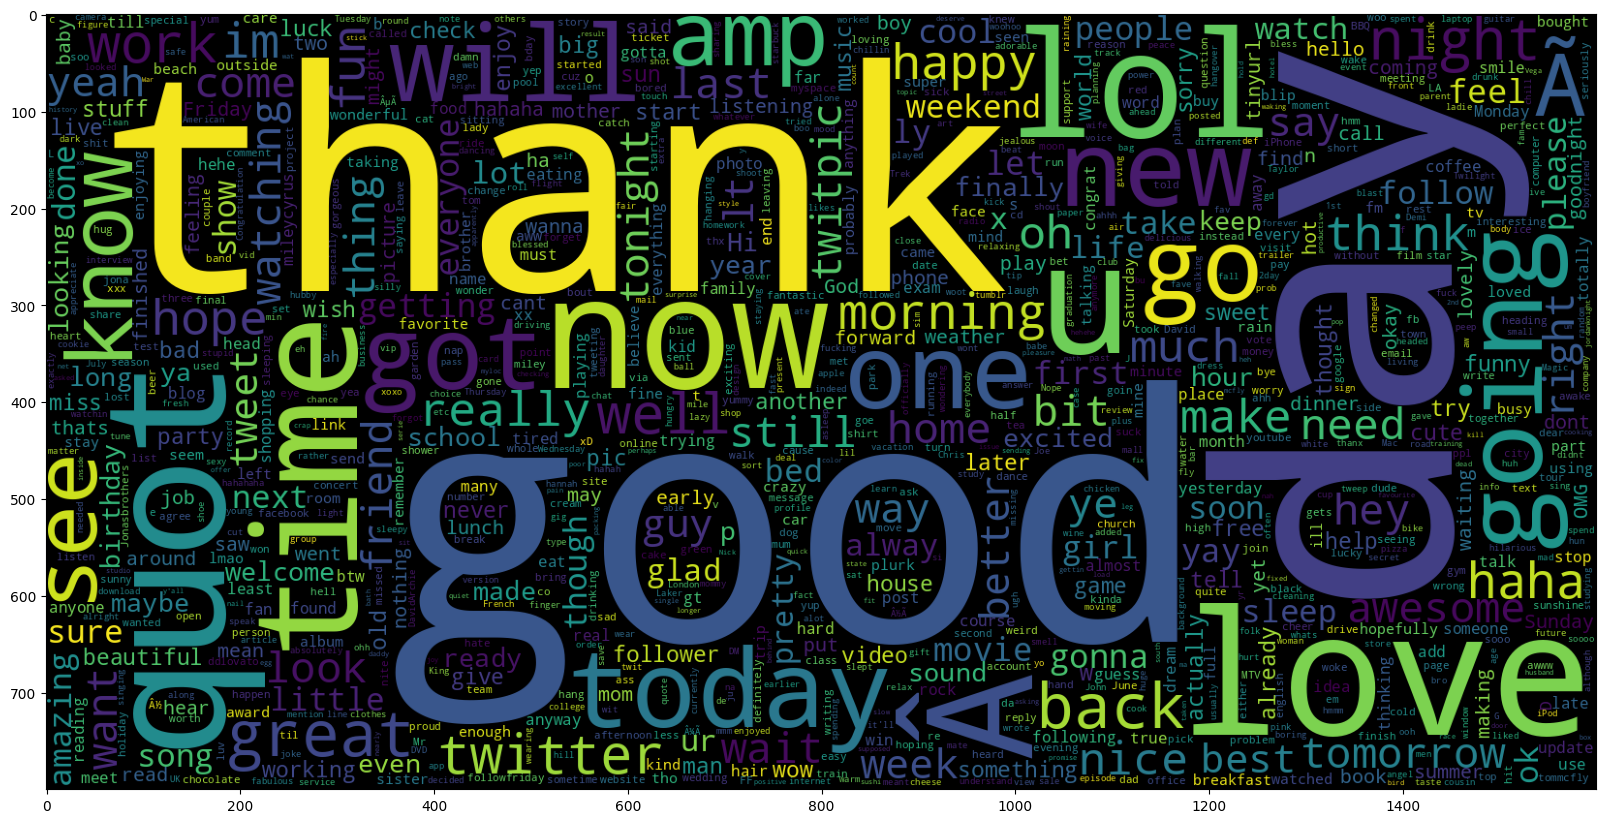

In [ ]:
# positive word cloud
data_positive = train_data[train_data.sentiment == 4].text

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_positive))
plt.figure(figsize = (20,20))
plt.imshow(wc)

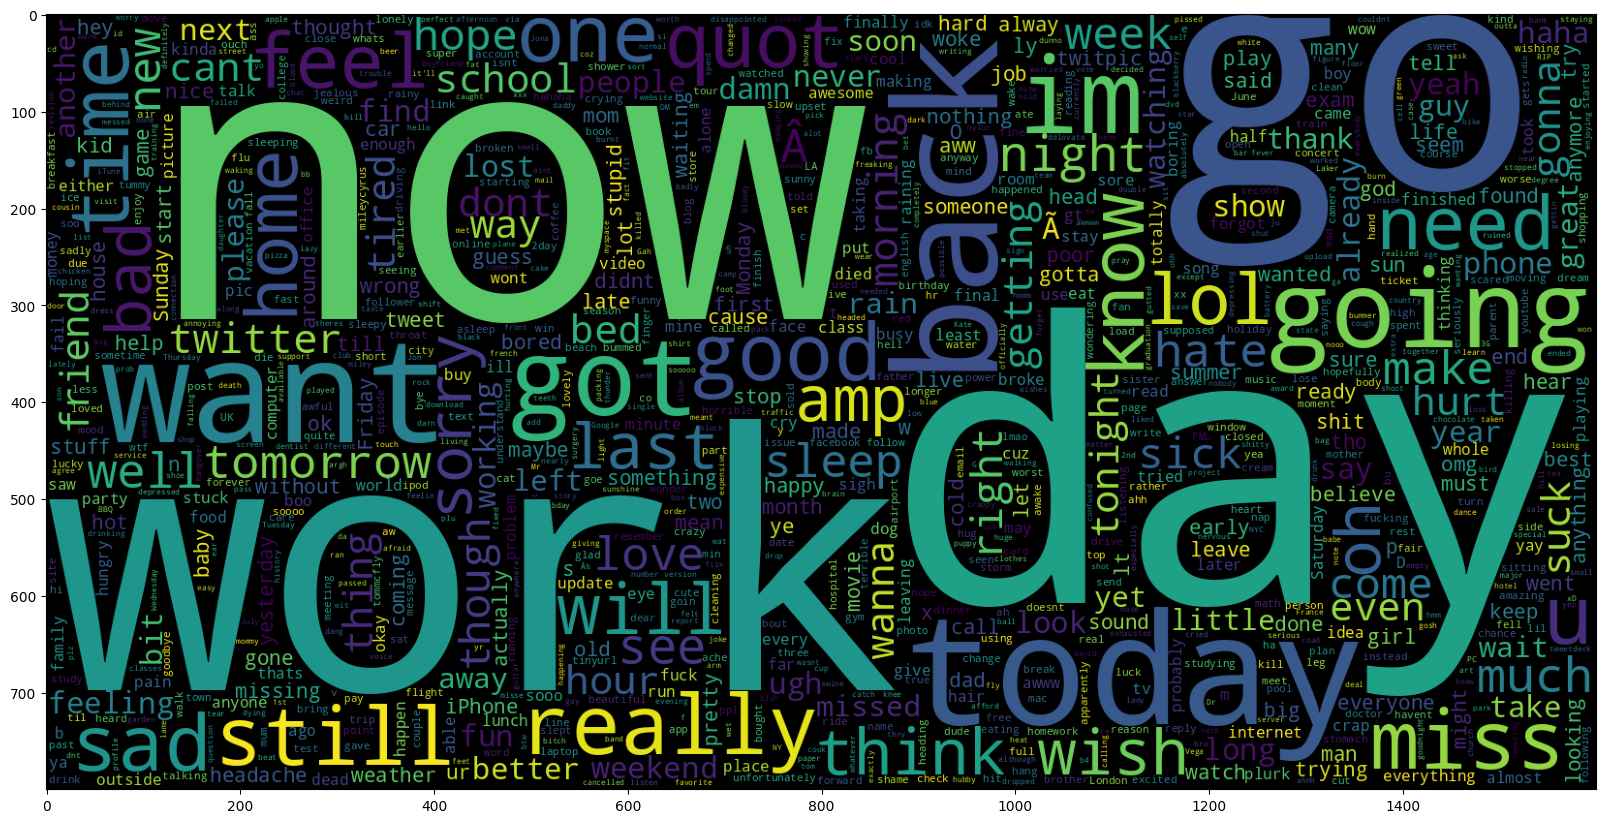

In [ ]:
# negative word cloud
data_negative = train_data[train_data.sentiment == 0].text

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_negative))
plt.figure(figsize = (20,20))
plt.imshow(wc)

# LSTM-CNN

## Pre-processing

In [ ]:
data = pd.read_csv(dataset_path, encoding="ISO-8859-1")
train_data, test_data = train_test_split(data, test_size=0.2, random_state=13)
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(data.text, data.sentiment, test_size=0.2, random_state=13)

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
          "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
          "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
          "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
          "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
          "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
          "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
          "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
          "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
          "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
          "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
          "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
          "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
          "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
          "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
          "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
          "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
          "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
          "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
          "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
          "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
          "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern = '@[^\s]+'
alphaPattern = "[^a-z0-9]+"
sequencePattern = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji = r"[8:=;]['`\-]?[)d]+"
sademoji = r"[8:=;]['`\-]?\(+"
lolemoji = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URLs with 'url'
    tweet = re.sub(urlPattern, 'url', tweet)

    # Replace @USERNAME with 'username'
    tweet = re.sub(userPattern, 'username', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', 'love', tweet)
    tweet = re.sub(smileemoji, 'happy', tweet)
    tweet = re.sub(sademoji, 'sad', tweet)
    tweet = re.sub(lolemoji, 'lol', tweet)

    for contraction, replacement in contraction_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)

    return tweet

X_train_text = X_train_data.apply(preprocess_apply)
X_test_text = X_test_data.apply(preprocess_apply)

In [ ]:
# Create CBOW Word2Vec model with embedding dimension is 200;
# min_count = 5 (ignores all words with total frequency lower than 5)
Word2vec_train_data = list(map(lambda x: x.split(), X_train_text))
d_embed = 200
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=d_embed, workers=8, min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 17777


In [ ]:
# tokenize
X_train_text_tokenized = X_train_text.apply(word_tokenize)
X_test_text_tokenized = X_test_text.apply(word_tokenize)

In [ ]:
# get word list and word2index dict.

def get_word_list_and_word2index(text):
    word_list = []

    # sentences to words list
    for tokens in text:
        word_list += tokens
    
    # count and delete words that total frequency no more than 3
    word_count = Counter(word_list)
    keys_list = list(word_count.keys())
    for token in keys_list:
        if word_count[token] <= 5 and (not word2vec_model.wv.__contains__(token)):
            del word_count[token]
    
    # add '[PAD]' and '[UNKNOWN]'
    word_set = set(word_count.keys())
    word_set.add('[PAD]')
    word_set.add('[UNKNOWN]')

    # get word list and word2index dict
    word_list = list(word_set) 
    word_list.sort()
    word2index = {}
    ind = 0
    for word in word_list:
        word2index[word] = ind
        ind += 1
    return word_list, word2index

word_list, word2index = get_word_list_and_word2index(X_train_text_tokenized)

In [ ]:
# get embedding table

def get_embedding_table(word_list):
    # shape of output embedding table should be (len(word_list), embedding dimension)
    embedding_table = []

    for i, word in enumerate(word_list):
        # if word in word2vec model, add its embedding
        if word2vec_model.wv.__contains__(word):
            embedding_table.append(word2vec_model.wv.__getitem__(word))
        
        # if not, add a random vector
        else:
            embedding_table.append(np.random.uniform(-1, 1, d_embed))
    return np.array(embedding_table)

embedding_table = get_embedding_table(word_list)

In [ ]:
# encode

# define the length of all sentences
seq_length = 64  

def encode_and_add_padding(text, seq_length):
    # shape of output sent_encoded should be (len(sentences), seq_length)
    sent_encoded = []
    for sent in text:
        # transform word to their index, use '[UNKNOWN]' if word not in word2vec model
        temp_encoded = [word2index[word] if word in word2index else word2index['[UNKNOWN]'] for word in sent][:seq_length]

        # add '[PAD]' if not long enough
        if len(temp_encoded) < seq_length:
            temp_encoded += [word2index['[PAD]']] * (seq_length - len(temp_encoded))

        sent_encoded.append(temp_encoded)
    return np.array(sent_encoded)

X_train_encoded = encode_and_add_padding(X_train_text_tokenized, seq_length)
X_test_encoded = encode_and_add_padding(X_test_text_tokenized, seq_length)

In [ ]:
# encode y

y_train_encoded = np.array(y_train_data / 4)
y_test_encoded = np.array(y_test_data / 4)

## Model

In [ ]:
# Model

class Model(nn.Module):
  
    def __init__(self, vocab_size, d_embed, hidden_dim, dropout):
        super().__init__()
        # embedding
        self.embedding = nn.Embedding(vocab_size, d_embed)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_table))

        # bi-lstm
        self.lstm1 = nn.LSTM(d_embed, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)

        # dropout
        self.dropout = nn.Dropout(dropout)

        # convolution
        self.conv = nn.Conv1d(2*hidden_dim, 2*hidden_dim, 5, padding=2)

        # linear
        self.linear1 = nn.Linear(2*hidden_dim, 16)
        self.linear2 = nn.Linear(16, 1)


    def forward(self, input):
        x = self.embedding(input)
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv(x))
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        x = F.relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        return x

In [ ]:
# create model

# learning rate, after tuning manually from (0.3, 0.2, 0.1, 0.01, 0.001, 0.0001, 0.00001), 1e-4 is best
LEARNING_RATE = 0.0001

vocab_size = len(word_list)
hidden_dim = 100
dropout = 0.3

model = Model(vocab_size, d_embed, hidden_dim, dropout).to(device)

# Binary Cross Entropy Loss
criterion = nn.BCELoss()

# adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# create train and validation data loader.
# batch_size = 1024

X_train, X_validation, y_train, y_validation = train_test_split(X_train_encoded, y_train_encoded, test_size=0.1, random_state=0)

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).float())
train_loader = DataLoader(dataset=train_data, batch_size=1024, shuffle=False)

validation_data = TensorDataset(torch.from_numpy(X_validation), torch.from_numpy(y_validation).float())
validation_loader = DataLoader(dataset=validation_data, batch_size=1024, shuffle=False)

In [ ]:
epoch = 100

# If the loss of the current epoch is not smaller than the one before 3 epochs, stop
early_stop_round = 3

train_loss_list = []
valid_loss_list = []

pre_time = time.time()

for i in range(epoch):
    # train
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data).view(-1)
        
        pred = torch.round(output)

        correct += (pred == target).sum().item()
        total += len(data)

        loss = criterion(output, target)

        # count train loss for each epoch
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if ((batch_idx+1) % 10) == 1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss:{:.6f}'.format(i+1, batch_idx, len(train_loader), 100.*batch_idx/len(train_loader), loss.item()))
            
    train_loss /= len(train_loader)

    # record train loss of each epoch
    train_loss_list.append(train_loss)

    print("Train Loss: {}".format(train_loss))
    accuracy = 100. * correct / total
    print('correct: {}, total: {}, accuracy of train: {:.2f}%'.format(correct, total, accuracy))

    # validation
    model.eval()
    correct = 0
    total = 0
    valid_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validation_loader):
            data, target = data.to(device), target.to(device)
            output = model(data).view(-1)
            pred = torch.round(output)
            correct += (pred == target).sum().item()
            total += len(data)
            batch_loss = criterion(output, target)

            # count valid loss
            valid_loss += batch_loss.item()

    valid_loss /= len(validation_loader)

    # record validation loss for each epoch 
    valid_loss_list.append(valid_loss)

    print("Validation Loss: {}".format(valid_loss))
    accuracy = 100. * correct / total
    print('correct: {}, total: {}, accuracy of validation: {:.2f}%'.format(correct, total, accuracy))

    # early stop
    if len(valid_loss_list) > early_stop_round and valid_loss_list[-(early_stop_round + 1)] - valid_loss_list[-1] < 0.0001:
        break

print("time to train: ", time.time() - pre_time)

Train Epoch: 1 [0/211 (0%)]	Loss:0.702563
Train Epoch: 1 [10/211 (5%)]	Loss:0.692712
Train Epoch: 1 [20/211 (9%)]	Loss:0.692404
Train Epoch: 1 [30/211 (14%)]	Loss:0.690098
Train Epoch: 1 [40/211 (19%)]	Loss:0.686503
Train Epoch: 1 [50/211 (24%)]	Loss:0.680457
Train Epoch: 1 [60/211 (28%)]	Loss:0.662400
Train Epoch: 1 [70/211 (33%)]	Loss:0.636175
Train Epoch: 1 [80/211 (38%)]	Loss:0.598548
Train Epoch: 1 [90/211 (43%)]	Loss:0.553477
Train Epoch: 1 [100/211 (47%)]	Loss:0.563125
Train Epoch: 1 [110/211 (52%)]	Loss:0.547337
Train Epoch: 1 [120/211 (57%)]	Loss:0.516891
Train Epoch: 1 [130/211 (62%)]	Loss:0.500216
Train Epoch: 1 [140/211 (66%)]	Loss:0.509381
Train Epoch: 1 [150/211 (71%)]	Loss:0.509372
Train Epoch: 1 [160/211 (76%)]	Loss:0.496502
Train Epoch: 1 [170/211 (81%)]	Loss:0.495492
Train Epoch: 1 [180/211 (85%)]	Loss:0.492719
Train Epoch: 1 [190/211 (90%)]	Loss:0.508371
Train Epoch: 1 [200/211 (95%)]	Loss:0.484803
Train Epoch: 1 [210/211 (100%)]	Loss:0.492311
Train Loss: 0.579866525

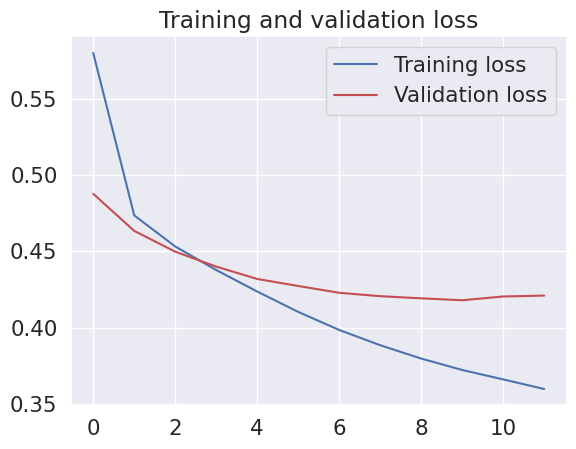

In [ ]:
loss, val_loss = train_loss_list, valid_loss_list
epochs = range(1, len(train_loss_list) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluation

In [ ]:
# evaluation

# create test loader
test_data = TensorDataset(torch.from_numpy(X_test_encoded), torch.from_numpy(y_test_encoded).float())
test_loader = DataLoader(dataset=test_data, batch_size=1024)

pred_logist = []
actual = []
pre_time = time.time()
for batch_idx, (data, target) in enumerate(test_loader):
    model.eval()
    data, target = data.to(device), target.to(device)
    output = model(data).view(-1)
    pred_logist += [i.cpu().item() for i in output]
    actual += [i.cpu().item() for i in target]

pred = [1 if i > 0.5 else 0 for i in pred_logist]
print("time to predict: ", time.time() - pre_time)

ltsm_cnn_cm = metrics.confusion_matrix(actual, pred)
ltsm_cnn_cr = metrics.classification_report(actual, pred)

print(ltsm_cnn_cr)
print(ltsm_cnn_cm)

time to predict:  4.7487897872924805
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82     29957
         1.0       0.83      0.77      0.80     30043

    accuracy                           0.81     60000
   macro avg       0.81      0.81      0.81     60000
weighted avg       0.81      0.81      0.81     60000

[[25297  4660]
 [ 6797 23246]]


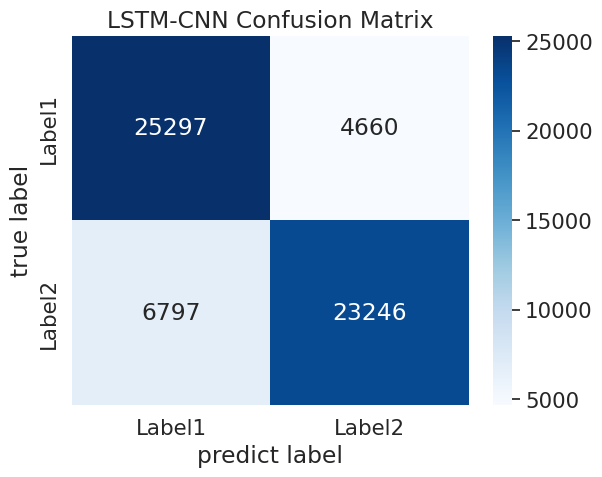

In [ ]:
sns.set(font_scale=1.4)
sns.heatmap(ltsm_cnn_cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Label1', 'Label2'], yticklabels=['Label1', 'Label2'])
plt.xlabel('predict label')
plt.ylabel('true label')
plt.title('LSTM-CNN Confusion Matrix')
plt.show()